In [1]:
### IMF CDIS DATASET ANALYSIS

In [11]:
### INITIALIZATION

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import gc

In [3]:
### DEFINING COUNTRY CODES EXTRACTOR

def get_country_codes(use_local_copy = False):  
    ### In case if URL is unavailable:
    if (use_local_copy):
        url_country_code = 'Data_Files/Source_Files/countrycode.html'
    ### Online extraction:
    else:
        url_country_code = 'https://countrycode.org/'
    df_full_codes = pd.read_html(url_country_code, index_col = 'COUNTRY')[0]
    df_full_codes[['ISO SHORT', 'ISO LONG']] = df_full_codes['ISO CODES'].str.split(' / ', expand = True)
    df_result = df_full_codes[['ISO SHORT', 'ISO LONG']].sort_index()    
    df_result.index = df_result.index.str.upper()
    ### Results output:
    return df_result

In [4]:
### DEFINING EXTRACTION UNIVERSE DATA FROM MS EXCEL SOURCE (TO BE IGNORED IN PRODUCT CODE)

def ison_membership_converting(str_path_universe, date_end, bool_daily = False, int_backfill_months = 0):
    ### Defining business-month-end reindexation on country level:
    def country_modify(ser_raw_country, date_end):
        ser_res_country = ser_raw_country.droplevel(0).resample('MS').last().resample('BM').last()
        range_country = pd.date_range(ser_res_country.index[0], date_end, freq = 'BM')
        return ser_res_country.reindex(range_country).ffill()
    ### Markets encoding table:
    dict_markets = {50 : 'DM', 57 : 'EM', 504 : 'FM', 0: np.NaN}     
    ### Loading source file:
    df_raw_universe = pd.read_excel(engine = 'openpyxl', io = str_path_universe, sheet_name = 'Switchers', header = 0, parse_dates = True, index_col = [0, 1],
                                 na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                             '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'], keep_default_na = False)
    ### Converting source file:
    df_raw_universe.index.names = ['Country', 'Date']
    ser_raw_universe = df_raw_universe['Region']
    ser_raw_universe.fillna(0, inplace = True)
    ser_raw_universe.name = 'Market'
    ### By country reindexation and translation:
    ser_res_universe = ser_raw_universe.groupby('Country').apply(country_modify, date_end)
    ser_res_universe.index.names = ['Country', 'Date']
    ser_res_universe = ser_res_universe.replace(dict_markets).reorder_levels([1, 0]).sort_index() 
    ### Expanding membership for primary regions members by backfilling:
    if int_backfill_months:
        ### List of regions:
        list_region = list(ser_res_universe.dropna().unique())
        ### Initialising of collection of series with backfilled data for each region:
        list_ison_backfill = []
        ### Regions looping:
        for iter_region in list_region:
            ### Defining start of region date:
            date_first_valid = ser_res_universe.loc[ser_res_universe == iter_region].first_valid_index()[0]
            ### Creating dates index to backfilling:
            idx_date_backfill = pd.date_range(end = date_first_valid, periods = int_backfill_months + 1, freq = 'BM')[: -1]
            ### Creating primary countries index to backfilling:            
            idx_region_backfill = ser_res_universe.loc[ser_res_universe == iter_region].loc[date_first_valid, All].index.get_level_values('Country')
            ### Creating full index:
            idx_ison_backfill = pd.MultiIndex.from_product([idx_date_backfill, idx_region_backfill])
            ### Series with backfilled data:
            list_ison_backfill.append(pd.Series(iter_region, index = idx_ison_backfill))
        ### Combination of backfilled series and original ISON data:    
        ser_res_universe = ser_res_universe.combine_first(pd.concat(list_ison_backfill, axis = 0)).sort_index()  
        ser_res_universe.index.names = ['Date', 'Country']
    ### Converting to daily frequency:
    if bool_daily:
        ser_res_universe = ser_res_universe.reset_index('Country').groupby('Country').resample('B').ffill()['Market'].swaplevel().sort_index()    
    ### Results output:
    ser_res_universe.name = 'Market'
    return ser_res_universe

In [5]:
### NEED TO BE ADOPTED: COMMON DATA EXTRACTION STEPS

### MultiIndex level slice constant:
All = slice(None)
### Universe path:
str_path_universe = 'Data_Files/Source_Files/acadian_universe.xlsx'
### Technical Constants:
str_date_end = '2022-10-31'
### World Country Codes:
df_country_codes = get_country_codes()
### ISON membership history:
ser_ison_membership = ison_membership_converting(str_path_universe, pd.to_datetime(str_date_end))
### ISON SHORT IDs list:
list_ison_countries = sorted(list(map(str, ser_ison_membership.index.get_level_values(1).unique())))
### ISON LONG IDs list:
list_ison_long = list(df_country_codes.loc[df_country_codes['ISO SHORT'].isin(ser_ison_membership.index.get_level_values('Country').unique()), 'ISO LONG'].values)
### ISON current status:
ser_ison_status = ser_ison_membership.loc[str_date_end].droplevel('Date')
### ISON stats:
int_ison_number = len(list_ison_long)
list_regions = ['DM', 'EM', 'FM']
dict_ison_len = {}
dict_ison_len['Full Universe'] = int_ison_number
for iter_region in list_regions:
    dict_ison_len[iter_region] = len(ser_ison_status[ser_ison_status == iter_region])
ser_market_len = pd.Series(dict_ison_len)
ser_market_len.index.names = ['Market']    

In [13]:
### IMF CDIS: DATA KEEPING PARAMETERS

### Filtered dataset:
str_path_imf_cdis_dataset = 'Data_Files/Source_Files/cdis_assets.h5'
str_key_do_debt_imf_cdis_dataset = 'cdis_debt_outward_assets'
str_key_di_debt_imf_cdis_dataset = 'cdis_debt_inward_assets'
### Resulting dataset:
str_path_imf_cdis_augmented = 'Data_Files/Source_Files/cdis_augmented_unconditional.h5'
str_key_imf_cdis_augmented = 'cdis_asset_augmented'
### Technical Constants:
str_date_end = '2022-10-31'
date_start = pd.Timestamp('1989-12-29')
date_end = pd.Timestamp(str_date_end)
date_ison = pd.Timestamp('1994-12-31')

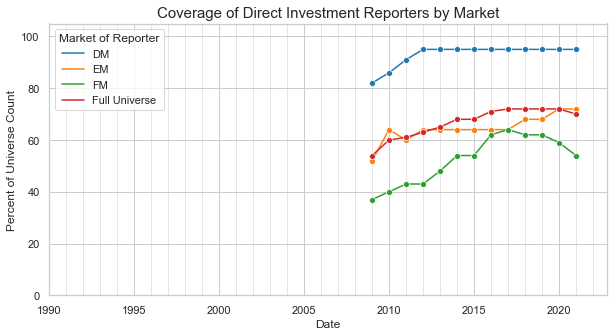

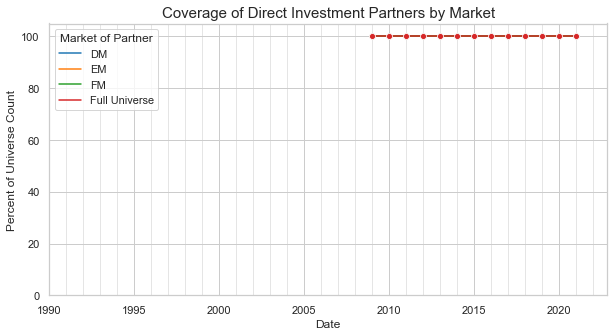

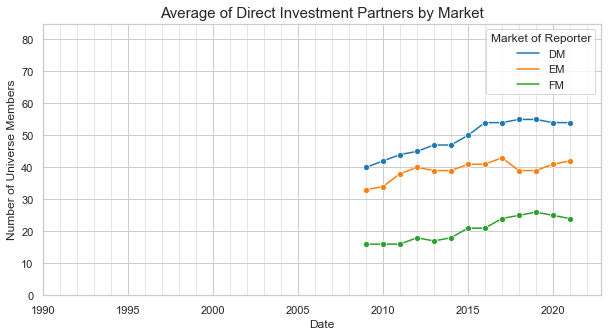

In [24]:
### IMF CDIS: STATS: ASSET COVERAGE: PARTICIPANTS NUMBER

gc.collect()
### Adding regions of reporters and partners:
ser_ison_status.index.names = ['Country']
ser_cdis_asset = pd.read_hdf(str_path_imf_cdis_dataset, str_key_do_debt_imf_cdis_dataset)
ser_cdis_asset.name = 'Value'
df_cdis_asset = ser_cdis_asset.reset_index()
df_cdis_asset = df_cdis_asset[df_cdis_asset['Value'] > 0.0]
df_coverage_full = df_cdis_asset.merge(ser_ison_status, left_on = 'Reporter', right_on = 'Country').merge(ser_ison_status, left_on = 'Partner', right_on = 'Country')
df_coverage_full.rename({'Market_x': 'Reporter_Market', 'Market_y': 'Partner_Market'}, axis = 1, inplace = True)
### Reporters number calculation start:
dict_reporters = {}
### Total reporters number:
ser_iter_reporters = df_coverage_full.groupby('Date')['Reporter'].apply(lambda ser_date: len(ser_date.unique()))
ser_iter_reporters.name = 'Percent'
dict_reporters['Full Universe'] = (ser_iter_reporters.dropna() / dict_ison_len['Full Universe'] * 100).astype(int)
### Region's reporters number:
for iter_region in list_regions:
    ser_iter_reporters = df_coverage_full[df_coverage_full['Reporter_Market'] == iter_region]\
                            .groupby('Date')['Reporter'].apply(lambda ser_date: len(ser_date.unique()))
    ser_iter_reporters.name = 'Percent'
    dict_reporters[iter_region] = (ser_iter_reporters.dropna() / dict_ison_len[iter_region] * 100).astype(int)
### Data consolidating:    
df_reporters = pd.concat(dict_reporters, axis = 0).unstack(0).resample('YS').last().stack(0).reset_index()
df_reporters.columns = ['Date', 'Market of Reporter', 'Percent']
df_to_plot = df_reporters[df_reporters['Date'] < date_end]
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_reporters = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percent', hue = 'Market of Reporter', hue_order = list_regions + ['Full Universe'], marker = 'o')
ax_reporters.set_title('Coverage of Direct Investment Reporters by Market', fontsize = 15)
ax_reporters.set(xlim = (date_start, date_end), ylim = (0, 105), ylabel = 'Percent of Universe Count')
### Major ticker options:    
ax_reporters.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_reporters.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_reporters.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_reporters.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()
### Partners number calculation start:
dict_partners = {}
### Total partners number:
ser_iter_partners = df_coverage_full.groupby('Date')['Partner'].apply(lambda ser_date: len(ser_date.dropna().unique()))
ser_iter_partners.name = 'Percent'
### Region's partners number:
dict_partners['Full Universe']  = (ser_iter_partners.resample('BY').last().dropna() / dict_ison_len['Full Universe'] * 100).astype(int)
for iter_region in list_regions:
    ser_iter_partners = df_coverage_full[df_coverage_full['Partner_Market'] == iter_region]\
                            .groupby('Date')['Partner'].apply(lambda ser_date: len(ser_date.dropna().unique()))
    ser_iter_partners.name = 'Percent'
    dict_partners[iter_region]  = (ser_iter_partners.resample('BY').last().dropna() / dict_ison_len[iter_region] * 100).astype(int)
### Data consolidating:        
df_partners = pd.concat(dict_partners, axis = 0).unstack(0).resample('YS').last().stack(0).reset_index()
df_partners.columns = ['Date', 'Market of Partner', 'Percent']
df_to_plot = df_partners[df_partners['Date'] < date_end]
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_partners = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percent', hue = 'Market of Partner', hue_order = list_regions + ['Full Universe'], marker = 'o')
ax_partners.set_title('Coverage of Direct Investment Partners by Market', fontsize = 15)
ax_partners.set(xlim = (date_start, date_end), ylim = (0, 105), ylabel = 'Percent of Universe Count')
### Major ticker options:    
ax_partners.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_partners.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_partners.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_partners.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()
### Average partners number calculation start:
dict_ave_partners = {}
### Region's partners average number:
for iter_region in list_regions:
    ser_iter_partners = df_coverage_full[df_coverage_full['Reporter_Market'] == iter_region]\
                                .groupby(['Date', 'Reporter'])['Partner'].apply(lambda ser_date: len(ser_date.unique())).groupby('Date').mean().astype(int)
    ser_iter_partners.name = 'Percent'
#    dict_ave_partners[iter_region] = (ser_iter_partners.resample('BY').last().dropna() / dict_ison_len[iter_region] * 100).astype(int)
    dict_ave_partners[iter_region] = ser_iter_partners.resample('BY').last().dropna().astype(int)    
### Data consolidating:         
df_partners = pd.concat(dict_ave_partners, axis = 0).unstack(0).resample('YS').last().stack(0).reset_index()
df_partners.columns = ['Date', 'Market of Reporter', 'Percent']
df_to_plot = df_partners[df_partners['Date'] < date_end]
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_partners = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percent', hue = 'Market of Reporter', hue_order = list_regions, marker = 'o')
ax_partners.set_title('Average of Direct Investment Partners by Market', fontsize = 15)
ax_partners.set(xlim = (date_start, date_end), ylim = (0, 85), ylabel = 'Number of Universe Members')
### Major ticker options:    
ax_partners.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_partners.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_partners.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_partners.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

IMF CDIS Assets: Total ISON Reporters number: 65
IMF CDIS Assets: Absent countries: ['AE', 'AR', 'CO', 'EC', 'EG', 'GH', 'JO', 'KE', 'NA', 'OM', 'PA', 'QA', 'RO', 'SA', 'SG', 'TN', 'TW', 'UA', 'UG', 'VN']


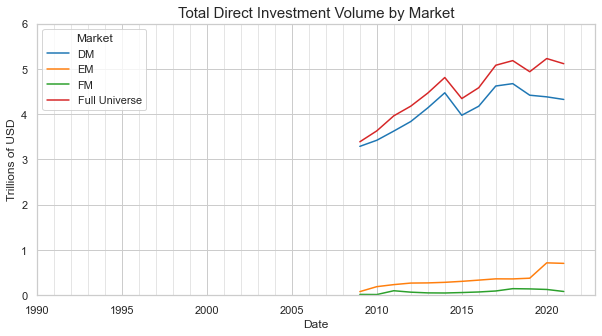

In [20]:
### IMF CDIS: STATS: EXPORT VOLUME

gc.collect()
print('IMF CDIS Assets: Total ISON Reporters number:', str(len(df_cdis_asset['Reporter'].unique())))
print('IMF CDIS Assets: Absent countries:', sorted(list(set(ser_ison_status.index) - set(df_cdis_asset['Reporter']))))
### Total export volume calculation start:
dict_total_volume = {}
### ISON total volume:
ser_ison_status.index.names = ['Reporter']
df_cdis_asset_isoned = df_cdis_asset.join(ser_ison_status, on = 'Reporter')
dict_total_volume['Full Universe'] = df_cdis_asset.groupby('Date')['Value'].sum() / 1000000
### Region's total volume:
for iter_region in list_regions:
    dict_total_volume[iter_region] = df_cdis_asset_isoned[df_cdis_asset_isoned['Market'] == iter_region].groupby('Date')['Value'].sum() / 1000000
### Data consolidating:    
df_volume = pd.concat(dict_total_volume).unstack(0).resample('YS').last().stack(0).reset_index()
df_volume.columns = ['Date', 'Market', 'Volume']
df_to_plot = df_volume[df_volume['Date'] < date_end]
### Total export volume plotting
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_total = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Volume', hue = 'Market', hue_order = ['DM', 'EM', 'FM', 'Full Universe'])
ax_total.set_title('Total Direct Investment Volume by Market', fontsize = 15)
ax_total.set(xlim = (date_start, date_end), ylabel = 'Trillions of USD', ylim = (0, 6))
### Major ticker options:    
ax_total.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_total.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_total.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_total.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

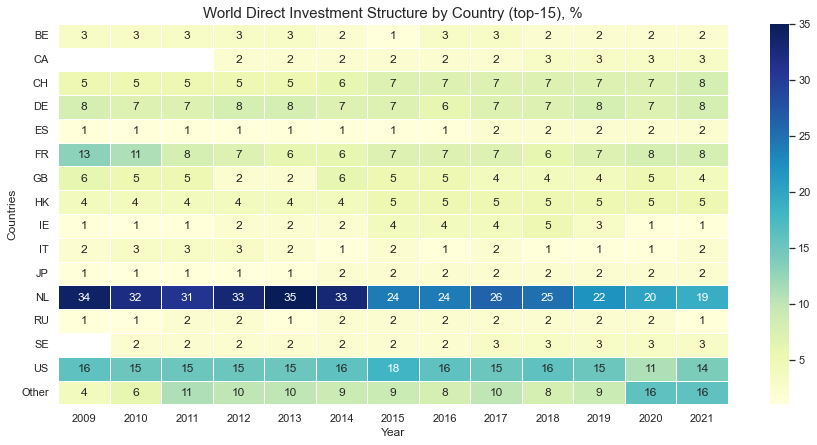

In [22]:
### IMF CDIS: STATS: ASSET LEADERS

gc.collect()
### Stats parameter - leaders to plot:
int_top = 15
### Stats parameter - years to define leaders:
int_term = 10
### Country trade proprotion for each date:
ser_country_value = df_cdis_asset.groupby(['Date', 'Reporter'])['Value'].sum().dropna() / 1000000
ser_total_volume = df_cdis_asset.groupby(['Date'])['Value'].sum().dropna() / 1000000
df_country_part = (ser_country_value / ser_total_volume).round(2).reset_index()
df_country_part['Year'] = df_country_part['Date'].dt.year
ser_country_part = df_country_part.set_index(['Year', 'Reporter']).drop('Date', axis = 1).squeeze().sort_index()
### Limited by term country trade volume:
ser_country_sum = ser_country_value.groupby('Reporter').apply(lambda ser_group: ser_group.iloc[-int_term :].sum()).sort_values(ascending = False)
### Top countries list:
idx_ave_top = ser_country_sum[: int_top].index
### Other countries list:
idx_ave_other = ser_country_sum[int_top :].index
### Top countries proportions extracting:
ser_country_top = (ser_country_part.loc[All, idx_ave_top] * 100)
ser_country_top.index.set_levels(ser_country_top.index.levels[1].astype('O'), level = 'Reporter', inplace = True) 
### Other countries proportions extracting:
ser_country_other = (ser_country_part.loc[All, idx_ave_other].groupby('Year').sum() * 100)
ser_country_other = pd.concat({'Other': ser_country_other[ser_country_other > 0]}, names = ['Reporter']).swaplevel()
### Data consolidating:
df_to_plot = pd.concat([ser_country_top.unstack('Year').sort_index(), ser_country_other.unstack('Year')], axis = 0)
### Results plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '.0f')
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('World Direct Investment Structure by Country (top-' + str(int_top) + '), %', fontsize = 15)
plt.yticks(rotation = 0)
plt.show()   

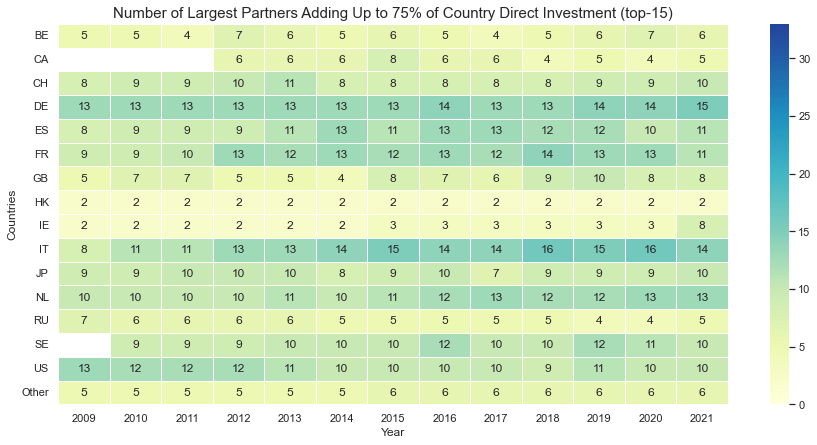

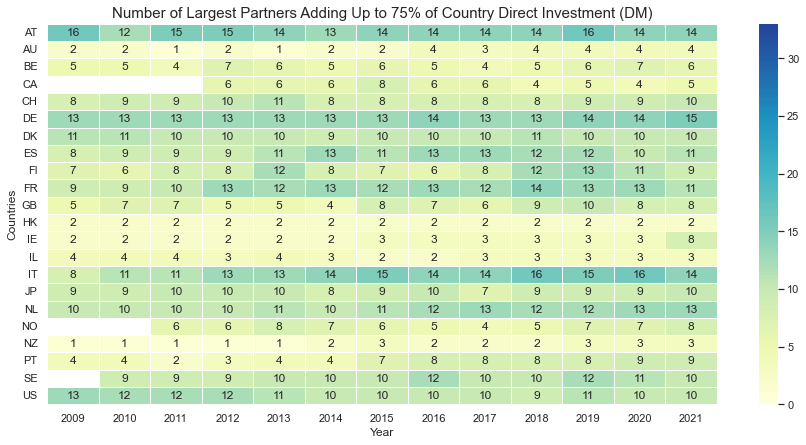

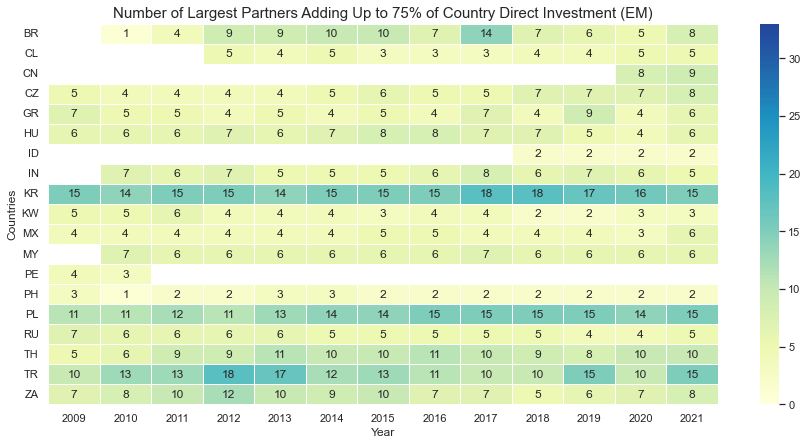

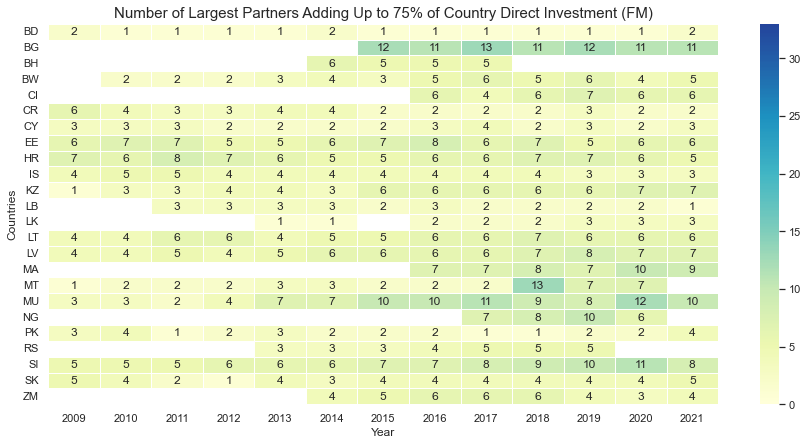

In [23]:
### ШЬА СВШЫ: STATS: NUMBER OF PARTNERS TO COMPLETE FIXED % OF EXPORT FOR COUNTRY

gc.collect()
### Defining top-% partners number calculation procedure:
def get_top_partners(ser_group, flo_perc):
    ser_by_partner = ser_group.groupby(['Date', 'Partner'])['Value'].sum().dropna().sort_values(ascending = False)
    ser_cum_sum = ser_by_partner.cumsum() / ser_by_partner.sum()
    return len(ser_cum_sum[ser_cum_sum < flo_perc]) + 1
### Stats parameter - top bound:
flo_perc = 0.75
### Stats parameter - leaders to plot:
int_top = 15
### Top countries list:
idx_ave_top = ser_country_sum[: int_top].index
### Other countries list:
idx_ave_other = ser_country_sum[int_top :].index
### Partners number calculation for each Date / Reporter pair:
ser_partners = df_cdis_asset.groupby(['Date', 'Reporter']).apply(get_top_partners, flo_perc).dropna().astype(int)
ser_partners.name = 'Number'
df_partners = ser_partners.to_frame().join(ser_ison_status, on = 'Reporter').reset_index()
### Leaders data extraction for leaders plot:
df_top_part = df_partners[df_partners['Reporter'].isin(idx_ave_top)].copy()
df_top_part['Year'] = df_top_part['Date'].dt.year
df_top_part = df_top_part.drop(['Date', 'Market'], axis = 1).set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = df_partners[df_partners['Reporter'].isin(idx_ave_other)].groupby('Date')['Number'].mean().astype(int).reset_index()
df_other_part['Year'] = df_other_part['Date'].dt.year
df_other_part = pd.concat({'Other': df_other_part.set_index('Year')}, names = ['Reporter'])
df_other_part = df_other_part.drop('Date', axis = 1).squeeze().unstack('Year')
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders plot plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         center = 20, vmin = 0, vmax = 33)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('Number of Largest Partners Adding Up to ' + str(int(flo_perc * 100)) + '% of Country Direct Investment (top-' + str(int_top) + ')', 
                     fontsize = 15)
plt.yticks(rotation = 0)
plt.show()
### Region's data plotting:
for iter_region in list_regions:
    ### Data extraction:    
    df_to_plot = df_partners.loc[df_partners['Market'] == iter_region].copy()
    df_to_plot['Year'] = df_to_plot['Date'].dt.year
    df_to_plot = df_to_plot.drop(['Date', 'Market'], axis = 1).set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
    ### Results plotting:
    plt.figure(figsize = (15, 7))
    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                             center = 20, vmin = 0, vmax = 33)
    ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
    ax_heatmap.set_title('Number of Largest Partners Adding Up to ' + str(int(flo_perc * 100)) + '% of Country Direct Investment (' + iter_region + ')', 
                         fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()  

In [50]:
### TEMP

ser_cdis_asset = pd.read_hdf(str_path_imf_cdis_dataset, str_key_do_debt_imf_cdis_dataset)
ser_cdis_liability_inv = pd.read_hdf(str_path_imf_cdis_dataset, str_key_di_debt_imf_cdis_dataset)
ser_cdis_liability = ser_cdis_liability_inv.reorder_levels([0, 2, 1])
ser_cdis_liability.index.names = ['Date', 'Reporter', 'Partner']
ser_cdis_liability = ser_cdis_liability.sort_index()

In [86]:
### OECD FDI: LIABILITY OBSERVATIONS INCORPORATION: DATA PREPARATION TO COMPARE FLOWS

gc.collect()
### Data loading:
ser_cdis_asset = pd.read_hdf(str_path_imf_cdis_dataset, str_key_do_debt_imf_cdis_dataset)
ser_cdis_liability_inv = pd.read_hdf(str_path_imf_cdis_dataset, str_key_di_debt_imf_cdis_dataset)
ser_cdis_liability = ser_cdis_liability_inv.reorder_levels([0, 2, 1])
ser_cdis_liability.index.names = ['Date', 'Reporter', 'Partner']
ser_cdis_liability = ser_cdis_liability.sort_index()
### Data concatenation:
ser_flows = pd.concat([ser_cdis_asset, ser_cdis_liability], axis = 0, keys = ['Asset', 'Liability'], names = ['Position'])
ser_flows = ser_flows.to_frame().join(ser_ison_status, on = 'Reporter').set_index('Market', append = True).squeeze()
ser_flows.replace({0.0: np.NaN}, inplace = True)

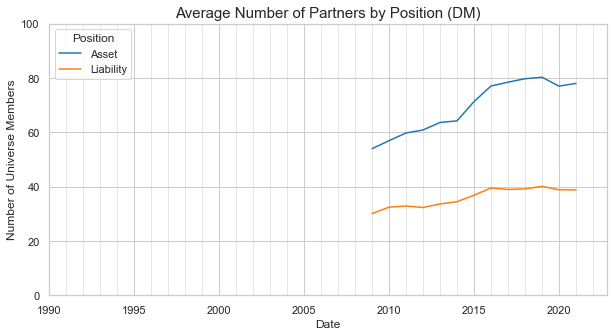

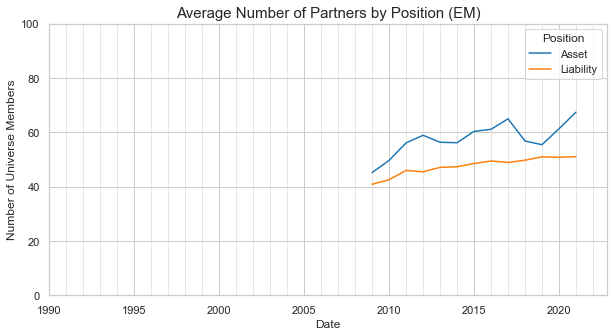

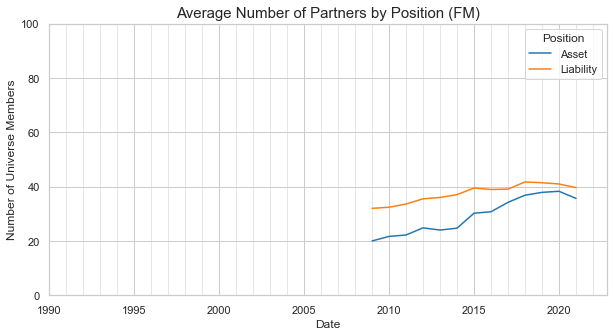

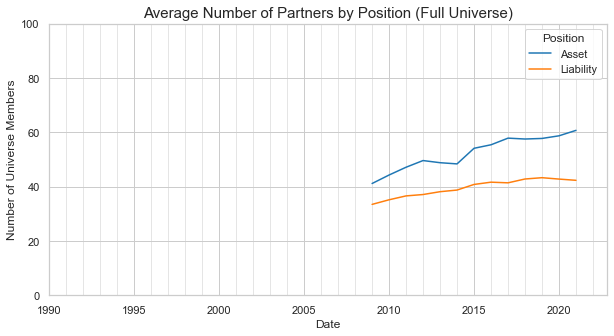

Number of observations for each position: 
 Position
Asset        39334
Liability    44458
dtype: int64


In [88]:
### OECD FDI: LIABILITY OBSERVATIONS INCORPORATION: COVERAGE COMPARING

gc.collect()
### Average partners number for Date / Reporter:
dict_obs_mean = {}
ser_reporter_mean = ser_flows.groupby(['Date', 'Reporter', 'Position', 'Market']).count()
ser_reporter_mean = ser_reporter_mean[ser_reporter_mean > 0]
dict_obs_mean['Full Universe'] = ser_reporter_mean.round(0).droplevel('Market').dropna().astype(int)
for iter_region in list_regions:
    dict_obs_mean[iter_region] = ser_reporter_mean.loc[All, All, All, iter_region].round(0).dropna().astype(int)
    ser_reporter_mean = ser_reporter_mean[ser_reporter_mean > 0]
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_obs_mean, axis = 0, names = ['Market of Reporter']).unstack(['Market of Reporter', 'Reporter', 'Position']).resample('YS').last()\
                                                                               .stack(['Market of Reporter', 'Reporter', 'Position']).reset_index()
df_to_plot.rename({0: 'Value'}, axis = 1, inplace = True)
### Region's data plotting:
for iter_region in list_regions + ['Full Universe']:
    ### Style coinfiguration:
    sns.set_style('whitegrid')
    plt.figure(figsize = (10, 5))
    sns.set_context('notebook')
    ### Plot creating:
    ax_partners = sns.lineplot(data = df_to_plot[df_to_plot['Market of Reporter'] == iter_region], x = 'Date', y = 'Value', hue = 'Position', ci = None)
    ax_partners.set_title('Average Number of Partners by Position (' + iter_region + ')', fontsize = 15)
    ax_partners.set(xlim = (date_start, date_end), ylabel = 'Number of Universe Members', ylim = (0, 100))
    ### Major ticker options:    
    ax_partners.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    ax_partners.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    ax_partners.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    ax_partners.grid(visible = True, which = 'minor', linewidth = 0.5) 
    ### Plot drawing:
    plt.show()
#    break
print('Number of observations for each position:', '\n', ser_flows.unstack('Position').count())

In [89]:
### IMF CPIS: LIABILITY OBSERVATIONS INCORPORATION: DATA PREPARATION TO INCORPORATE FLOWS

gc.collect()
### Data loading:
ser_cdis_asset = pd.read_hdf(str_path_imf_cdis_dataset, str_key_do_debt_imf_cdis_dataset)
ser_cdis_liability_inv = pd.read_hdf(str_path_imf_cdis_dataset, str_key_di_debt_imf_cdis_dataset)
### Data aggregation:
df_asset_aug = pd.concat([ser_cdis_asset, ser_cdis_liability_inv], axis = 1, names = 'Source Position', keys = ['Asset', 'Liability'])
df_asset_aug = df_asset_aug.join(ser_ison_status, on = 'Reporter').set_index('Market', append = True)
df_asset_aug.replace({0.0: np.NaN}, inplace = True)
df_asset_aug = df_asset_aug.drop('World', axis = 0, level = 'Reporter').drop('World', axis = 0, level = 'Partner')

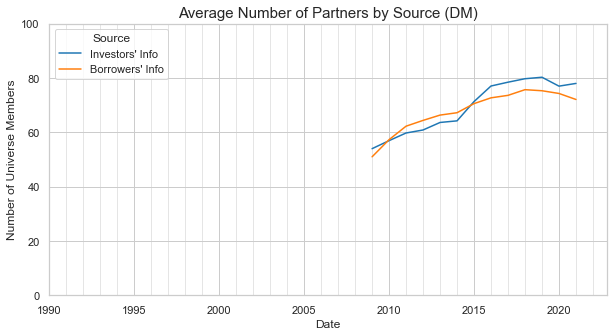

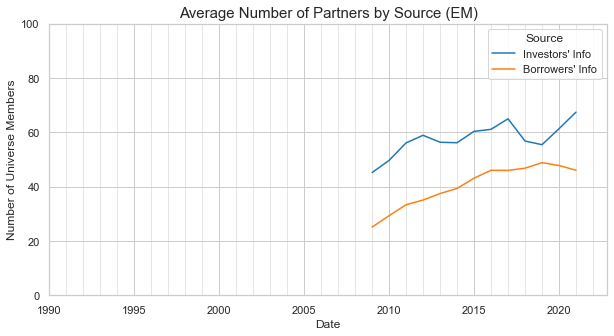

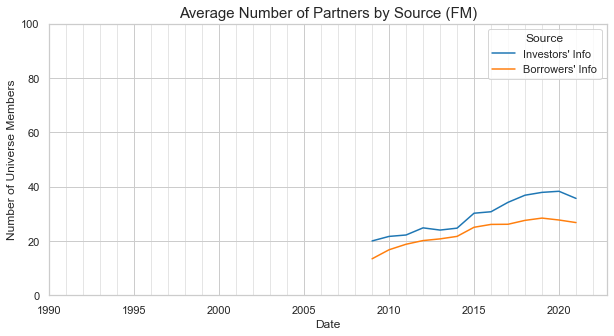

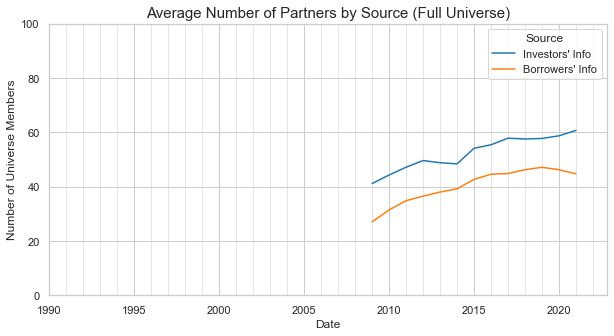

In [91]:
### OECD FDI: LIABILITY OBSERVATIONS INCORPORATION: COVERAGE COMPARING

gc.collect()
### Coverage data container:
dict_unique_mean = {}
### Partners number calculation:
dict_unique_mean['Investors\' Info'] = df_asset_aug['Asset'].groupby(['Date', 'Reporter', 'Market']).count()
dict_unique_mean['Borrowers\' Info'] = df_asset_aug['Liability'].groupby(['Date', 'Reporter', 'Market']).count()
ser_unique_mean = pd.concat(dict_unique_mean, axis = 0, names = ['Source']).round(0).dropna().astype(int)
ser_unique_mean = ser_unique_mean[ser_unique_mean > 0]
ser_unique_mean.name = 'Number of Partners'
del dict_unique_mean
gc.collect()
dict_unique_source = {}
dict_unique_source['Full Universe'] = ser_unique_mean.droplevel('Market').dropna()
for iter_region in list_regions:
    dict_unique_source[iter_region] = ser_unique_mean.loc[All, All, All, iter_region].dropna()
### Average partners number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_unique_source, axis = 0, names = ['Market of Investor']).unstack(['Market of Investor', 'Reporter', 'Source']).resample('YS').last()\
                                                                                    .stack(['Market of Investor', 'Reporter']).dropna(how = 'all')\
                                                                                    .stack('Source').reset_index()
df_to_plot.rename({0: 'Number of Partners'}, axis = 1, inplace = True)
### Region's data plotting:
for iter_region in list_regions + ['Full Universe']:
    ### Style coinfiguration:
    sns.set_style('whitegrid')
    plt.figure(figsize = (10, 5))
    sns.set_context('notebook')
    ### Plot creating:
    ax_partners = sns.lineplot(data = df_to_plot[df_to_plot['Market of Investor'] == iter_region], x = 'Date', y = 'Number of Partners', hue = 'Source', 
                               hue_order = ['Investors\' Info', 'Borrowers\' Info'], ci = None)
    ax_partners.set_title('Average Number of Partners by Source (' + iter_region + ')', fontsize = 15)
    ax_partners.set(xlim = (date_start, date_end), ylabel = 'Number of Universe Members', ylim = (0, 100))
    ### Major ticker options:    
    ax_partners.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    ax_partners.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    ax_partners.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    ax_partners.grid(visible = True, which = 'minor', linewidth = 0.5) 
    ### Plot drawing:
    plt.show()
#    break

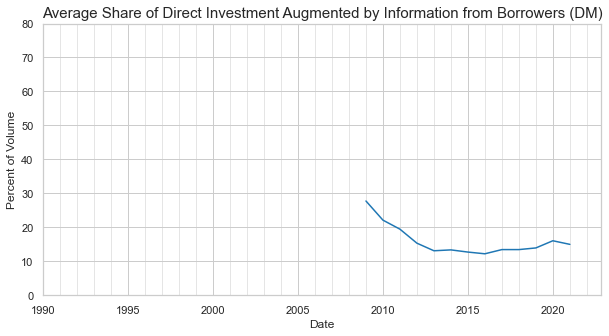

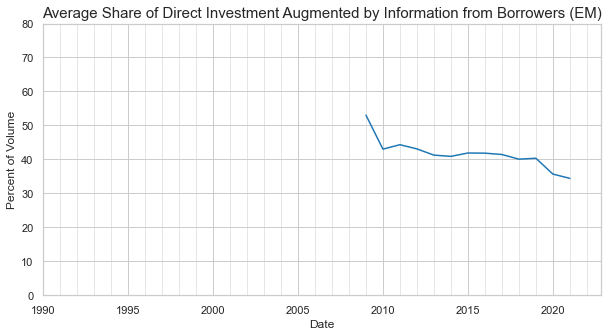

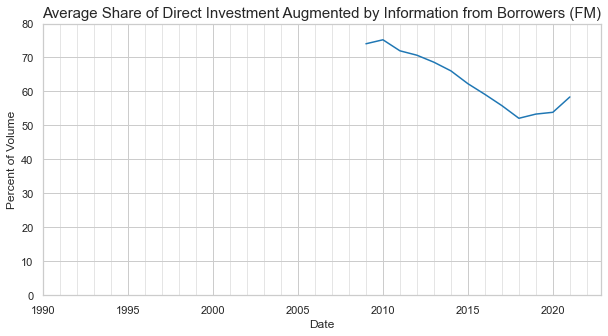

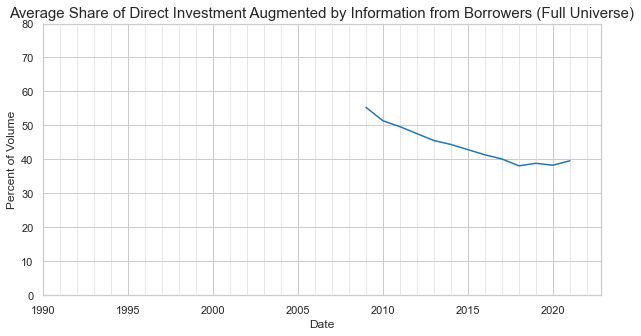

In [94]:
### OECD FDI: LIABILITY OBSERVATIONS INCORPORATION: UNIQUE INVERTED LIABILITIES VOLUME

gc.collect()
### Unique inverted import data filtering:
ser_liability_unique = df_asset_aug.loc[df_asset_aug['Asset'].isna() & df_asset_aug['Liability'].notna(), 'Liability']\
                                 .groupby(['Date', 'Reporter', 'Market']).sum()
ser_liability_unique_ann = ser_liability_unique.unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market'])
ser_liability_unique_ann.name = 'Added Volume'
### Unique inverted import by Market grouping:
dict_unique_liability = {}
dict_unique_liability['Full Universe'] = ser_liability_unique_ann.droplevel('Market').dropna()
for iter_region in list_regions:
    dict_unique_liability[iter_region] = ser_liability_unique_ann.loc[All, All, iter_region].dropna()
ser_liability_isoned = pd.concat(dict_unique_liability, axis = 0, names = ['Market of Investor'])
### Total export data filtering:
ser_asset_total = df_asset_aug['Asset'].groupby(['Date', 'Reporter', 'Market']).sum()
ser_asset_total_ann = ser_asset_total.unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market'])
ser_asset_total_ann.name = 'Asset Volume'
### Total export by Market grouping:
dict_asset_total = {}
dict_asset_total['Full Universe'] = ser_asset_total_ann.droplevel('Market').dropna()
for iter_region in list_regions:
    dict_asset_total[iter_region] = ser_asset_total_ann.loc[All, All, iter_region].dropna()
ser_asset_isoned = pd.concat(dict_asset_total, axis = 0, names = ['Market of Investor'])
### Share of Export Augmented by Information from Importers:
ser_share = (ser_liability_isoned.fillna(0) / (ser_liability_isoned.fillna(0) + ser_asset_isoned.fillna(0)) * 100).round(2)
### Dataset to draw:
df_to_plot = ser_share.unstack(['Market of Investor', 'Reporter']).resample('YS').last().stack(['Market of Investor', 'Reporter']).reset_index()
df_to_plot.rename({0: 'Share Added'}, axis = 1, inplace = True)
### Region's data plotting:
for iter_region in list_regions + ['Full Universe']:
    ### Style coinfiguration:
    sns.set_style('whitegrid')
    plt.figure(figsize = (10, 5))
    sns.set_context('notebook')
    ### Plot creating:
    ax_share = sns.lineplot(data = df_to_plot[df_to_plot['Market of Investor'] == iter_region], x = 'Date', y = 'Share Added', ci = None)
    ax_share.set_title('Average Share of Direct Investment Augmented by Information from Borrowers (' + iter_region + ')', fontsize = 15)
    ax_share.set(xlim = (date_start, date_end), ylabel = 'Percent of Volume', ylim = (0, 80))
    ### Major ticker options:    
    ax_share.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    ax_share.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    ax_share.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    ax_share.grid(visible = True, which = 'minor', linewidth = 0.5) 
    ### Plot drawing:
    plt.show()

In [95]:
### OECD FDI: LIABILITY DATA INCORPORATION:

### Combining Export & Import data:
df_asset_aug['Asset_Augmented'] = df_asset_aug['Asset'].replace({0.0: np.NaN}).combine_first(df_asset_aug['Liability'])

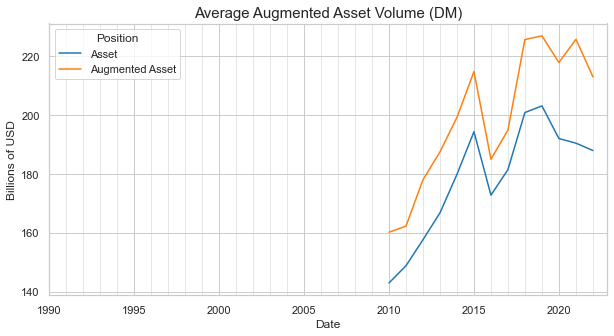

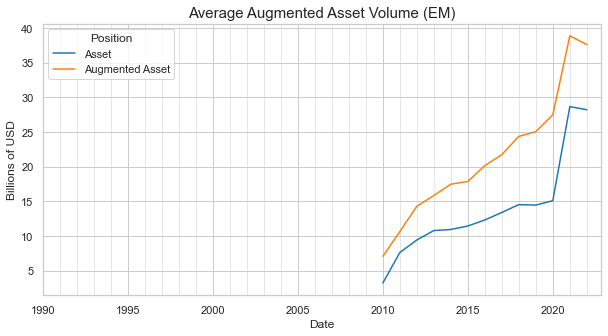

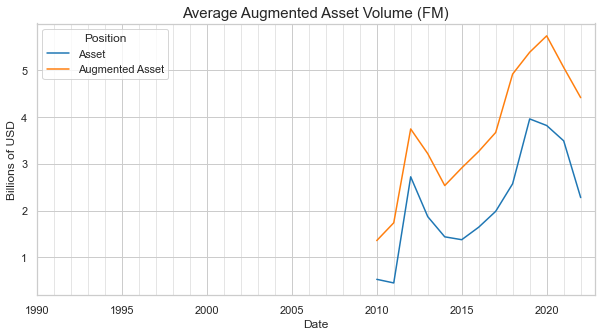

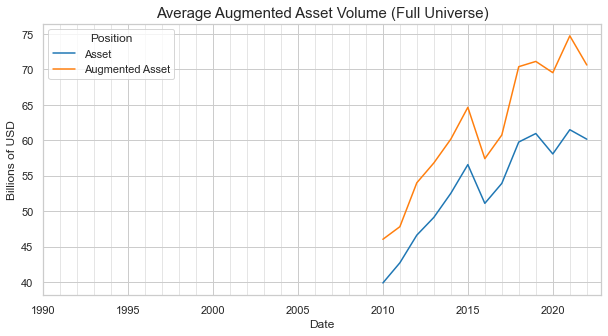

In [96]:
### IMF CPIS: LIABILITY OBSERVATIONS INCORPORATION: VISUALIZATION

gc.collect()

df_options_sum = df_asset_aug.groupby(['Date', 'Reporter', 'Market']).sum() / 1000
df_options_sum.columns = ['Asset', 'Liability', 'Augmented Asset']
ser_options_sum = df_options_sum[['Asset', 'Augmented Asset']].reset_index()\
                        .melt(id_vars = ['Date', 'Reporter', 'Market'], var_name = 'Position', value_name = 'Asset_Volume')\
                        .set_index(['Date', 'Reporter', 'Market', 'Position']).squeeze()
### Regions data aggregation:
dict_options_sum = {}
dict_options_sum['Full Universe'] = ser_options_sum.dropna().droplevel('Market')
for iter_region in list_regions:
    dict_options_sum[iter_region] = ser_options_sum.dropna().loc[All, All, iter_region, All]
### Export volume plotting:
df_to_plot = pd.concat(dict_options_sum, axis = 0, names = ['Market of Reporter']).reset_index()
df_to_plot.rename({0: 'Value'}, axis = 1, inplace = True)
### Region's data plotting:
for iter_region in list_regions + ['Full Universe']:
    ### Style coinfiguration:
    sns.set_style('whitegrid')
    plt.figure(figsize = (10, 5))
    sns.set_context('notebook')
    ### Plot creating:
    ax_volume = sns.lineplot(data = df_to_plot[df_to_plot['Market of Reporter'] == iter_region], x = 'Date', y = 'Asset_Volume', hue = 'Position', ci = None)
    ax_volume.set_title('Average Augmented Asset Volume (' + iter_region + ')', fontsize = 15)
    ax_volume.set(xlim = (date_start, date_end), ylabel = 'Billions of USD')
    ### Major ticker options:    
    ax_volume.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    ax_volume.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    ax_volume.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    ax_volume.grid(visible = True, which = 'minor', linewidth = 0.5) 
    ### Plot drawing:
    plt.show()
#    break

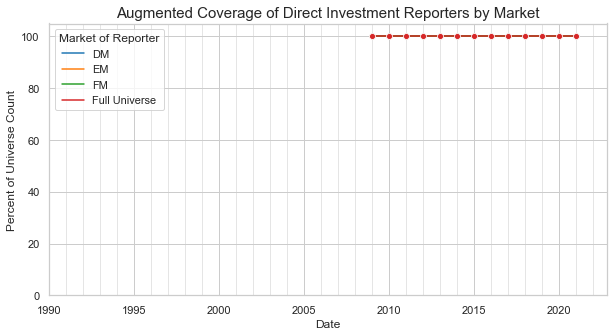

In [101]:
### OECD FDI: NUMBER OF REPORTERS CHANGE

dict_reporters = {}
### Data loading:
ser_imf_cdis = df_asset_aug['Asset_Augmented'].dropna()
### Total reporters number:
ser_iter_reporters = ser_imf_cdis.groupby('Date').apply(lambda ser_date: len(ser_date.index.get_level_values('Reporter').unique()))
ser_iter_reporters.name = 'Percent'
dict_reporters['Full Universe'] = (ser_iter_reporters.resample('BY').last().dropna() / dict_ison_len['Full Universe'] * 100).astype(int)
### Region's reporters number:
for iter_region in list_regions:
    ser_iter_reporters = ser_imf_cdis[:, :, :, iter_region].groupby('Date').apply(lambda ser_date: len(ser_date.index.get_level_values('Reporter').unique()))
    ser_iter_reporters.name = 'Percent'
    dict_reporters[iter_region] = (ser_iter_reporters.resample('BY').last().dropna() / dict_ison_len[iter_region] * 100).astype(int)
### Data consolidating:    
df_reporters = pd.concat(dict_reporters, axis = 0).unstack(0).resample('YS').last().stack(0).reset_index()
df_reporters.columns = ['Date', 'Market of Reporter', 'Percent']
df_to_plot = df_reporters[df_reporters['Date'] < date_end]
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_reporters = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percent', hue = 'Market of Reporter', hue_order = list_regions + ['Full Universe'], marker = 'o')
ax_reporters.set_title('Augmented Coverage of Direct Investment Reporters by Market', fontsize = 15)
ax_reporters.set(xlim = (date_start, date_end), ylim = (0, 105), ylabel = 'Percent of Universe Count')
### Major ticker options:    
ax_reporters.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_reporters.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_reporters.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_reporters.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

Last date reported: 2021-12-31 00:00:00


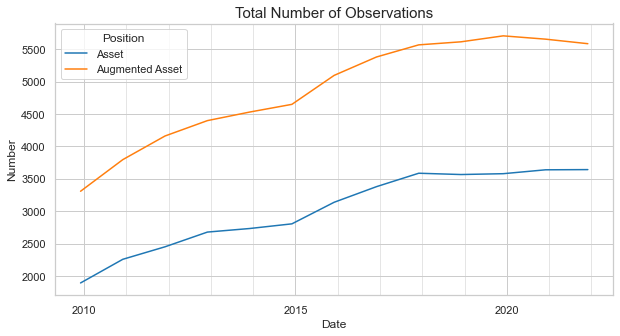

In [103]:
### OECD FDI: DATA FRESHNESS

df_imf_cdis = df_asset_aug.droplevel('Market').sort_index()[['Asset', 'Asset_Augmented']]
df_imf_cdis.columns = ['Asset', 'Augmented Asset']
ser_imf_cdis = df_imf_cdis.stack().sort_index()
ser_imf_cdis.index.names = ['Date', 'Reporter', 'Partner', 'Position']
print('Last date reported:', ser_imf_cdis.index.get_level_values('Date').max())
df_to_plot = ser_imf_cdis.groupby(['Date', 'Position']).count().sort_index().unstack('Position').resample('MS').last().stack('Position').reset_index()
df_to_plot.rename({0: 'Number'}, axis = 1, inplace = True)
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_number = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Number', hue = 'Position', hue_order = ['Asset', 'Augmented Asset'])
ax_number.set_title('Total Number of Observations', fontsize = 15)
### Major ticker options:    
ax_number.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_number.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_number.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_number.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

In [109]:
### IMF CPIS: AUGMENTED DATA LOADING

### Resulting dataset:
ser_cdis_asset = pd.read_hdf(str_path_imf_cdis_augmented, str_key_imf_cdis_augmented)

IMF CDIS : Countries not reported on the last observed date : []
IMF CDIS : Countries not reported on the last  60 observed months: []
IMF CDIS : Mean portion of partners available for the last observed date in proprotion to last 60 observed months average:


Market
DM    0.984026
EM    1.031387
FM    0.973947
Name: Proportion to average value, dtype: float64

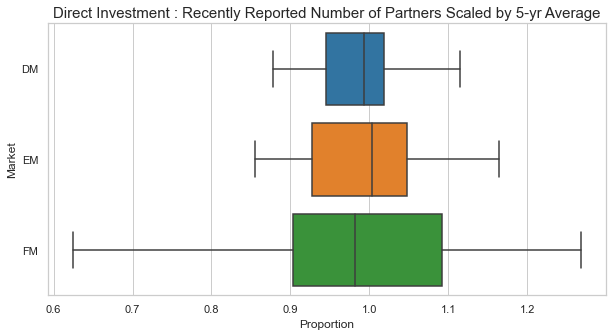

In [114]:
### IMF CPIS: LAST DATE COMPLETENESS CHECK

### Months to find maximum of partners for each reporter:
int_max_term = 60
### Region adding:
ser_ison_status.index.names = ['Reporter']
ser_isoned = ser_cdis_asset.to_frame().join(ser_ison_status).set_index('Market', append = True).squeeze()
### The most fresh date search:
list_dates_sorted = sorted(ser_isoned.index.get_level_values('Date').unique())
date_last = list_dates_sorted[-1]
date_prev = list_dates_sorted[-2]
### Last date partners number:
ser_last = ser_isoned[date_last].groupby(['Reporter', 'Market']).count()
### Maximum / Average partners number for the last years:
ser_mean = ser_isoned[date_last - pd.offsets.BMonthEnd(int_max_term) : date_prev].groupby(['Date', 'Reporter', 'Market']).count()\
                                                                                 .groupby(['Reporter', 'Market']).mean().dropna()    
### Last available proportion calculating:
print('IMF CDIS' + ' : Countries not reported on the last observed date :',  ser_last[ser_last == 0].droplevel('Market').index.to_list())
print('IMF CDIS' + ' : Countries not reported on the last  ' + str(int_max_term) + ' observed months:',  
      ser_mean[ser_mean == 0].droplevel('Market').index.to_list())
print('IMF CDIS' + ' : Mean portion of partners available for the last observed date in proprotion to last ' + str(int_max_term) + ' observed months average:')
ser_prop_to_mean = (ser_last / ser_mean)
ser_prop_to_mean.name = 'Proportion to average value'
display(ser_prop_to_mean.groupby('Market').mean())
if ((ser_prop_to_mean.quantile(0.05) / ser_prop_to_mean.quantile(0.95)) < 1 - 0.001):
    ### Last available proprortion to average distribution:
    df_to_plot = ser_prop_to_mean.reset_index()
    sns.set_style('whitegrid')
    plt.figure(figsize = (10, 5))
    sns.set_context('notebook')
    ax_box = sns.boxplot(data = df_to_plot, x = ser_prop_to_mean.name, y = 'Market', order = list_regions, showfliers = False)
    ax_box.set_title('Direct Investment' + ' : Recently Reported Number of Partners Scaled by 5-yr Average', fontsize = 15)
    ax_box.set_xlabel('Proportion')
    plt.show()
else:
    print('IMF CDIS' + ' : No boxplot to show')
#    break  

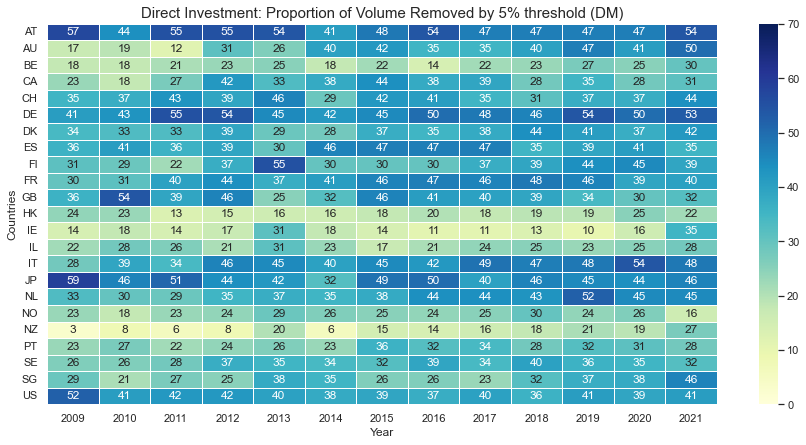

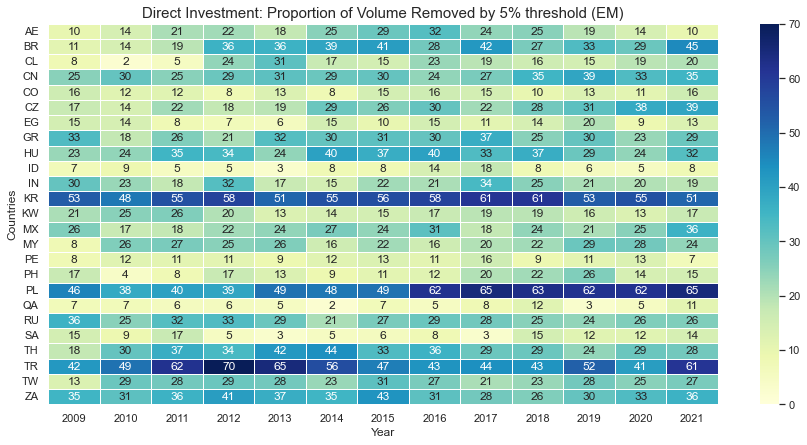

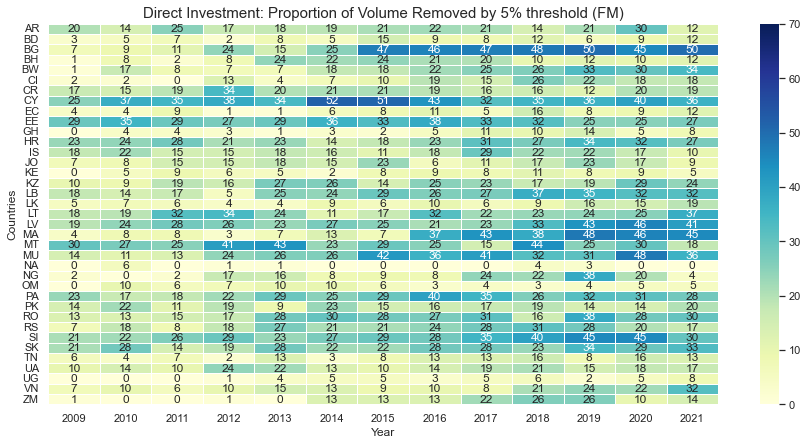

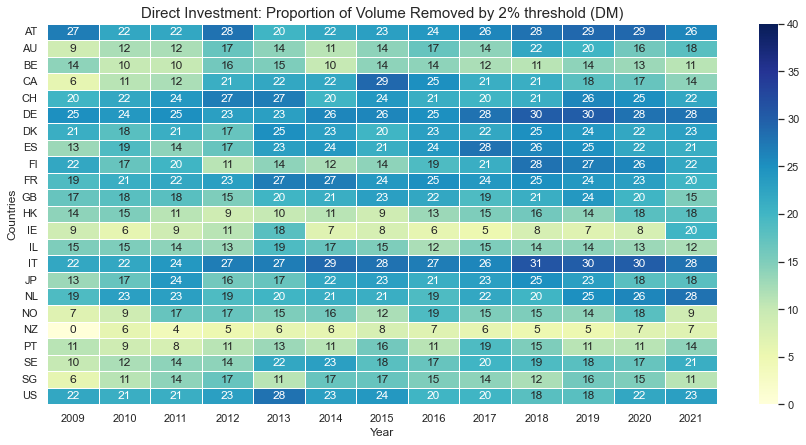

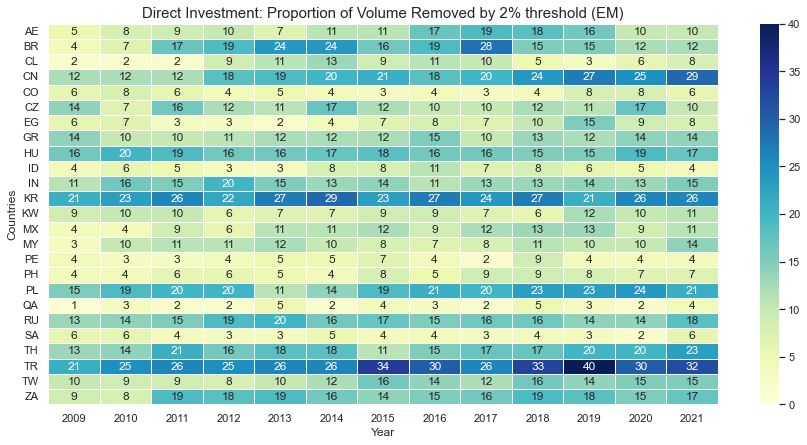

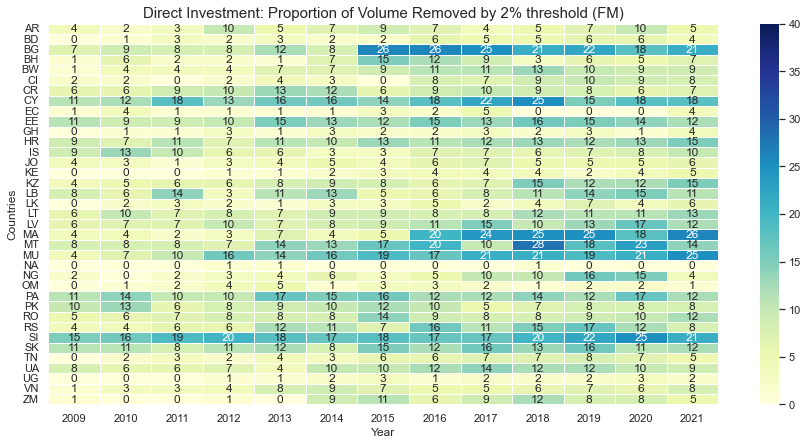

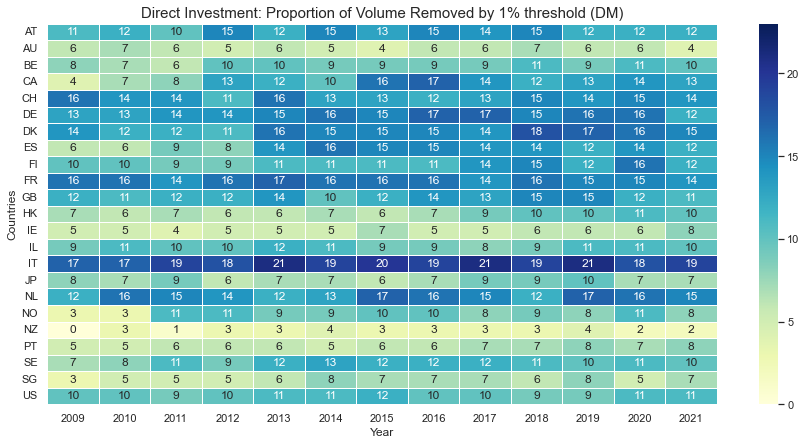

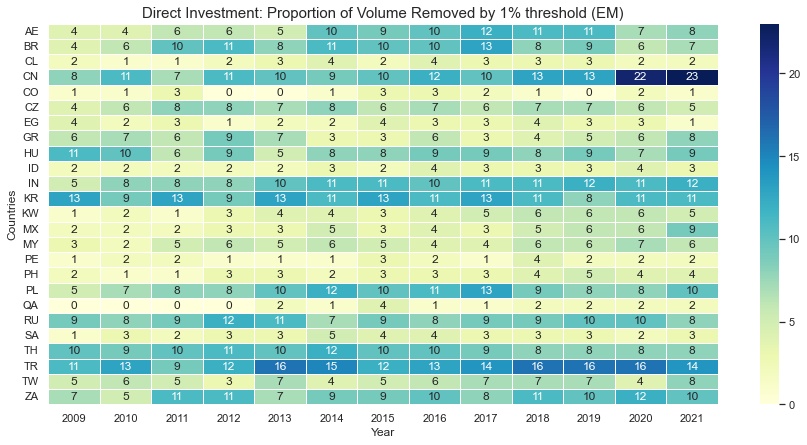

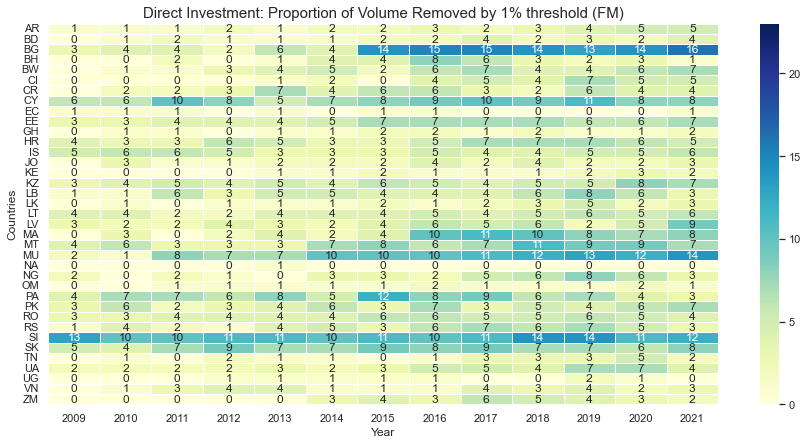

In [117]:
### IMF CPIS: THRESHOLD SIZE CALСULATION

### Defining threshold sum calculation:
def clip_threshold(ser_group, flo_limit = 0.05):
    ser_norm = ser_group / ser_group.sum()
    flo_threshold = ser_norm[ser_norm < flo_limit].sum()
    return flo_threshold
### Threshold limits options:
list_limits = [0.05, 0.02, 0.01]
### Looping over threshold limits:
for flo_limit in list_limits:
    gc.collect()
    ### Threshold sum for pairs initialization:
    dict_threshold_full = {}
    ### Mean thresholod sum for reporters initialization:
    dict_threshold_mean = {}

    ### Threshold sum calculation:
    ser_threshold_full = ser_cdis_asset.groupby(['Date', 'Reporter']).apply(clip_threshold, flo_limit)
    ser_threshold_mean = ser_threshold_full.unstack('Reporter').resample('BY').mean().stack('Reporter').sort_index()
    ### Mean threshold preparation to plot:
    ser_isoned = ser_threshold_mean.to_frame().join(ser_ison_status).set_index('Market', append = True).squeeze()
    ser_isoned = (ser_isoned * 100).astype(int)
    ### Looping over regions:
    for iter_region in list_regions:
        ### Dataset formatting:
        df_to_plot = ser_isoned.loc[:, :, iter_region].reset_index()
        df_to_plot['Year'] = df_to_plot['Date'].dt.year
        df_to_plot = df_to_plot.drop(['Date'], axis = 1).set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
        ### Results plotting:
        plt.figure(figsize = (15, 7))
        ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True,
                                 vmin = 0, vmax = ser_isoned.max())
        ### Plot formatting:
        ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
        ax_heatmap.set_title('Direct Investment' + ': Proportion of Volume Removed by ' + str(int(flo_limit * 100)) + '% threshold (' + iter_region + ')',
                             fontsize = 15)
        plt.yticks(rotation = 0)
        plt.show()  
#        break        

In [122]:
### IMF CDIS: ANNUALIZATION

### Annualization of differewnt frequency data definition:
def annualize(ser_group):
    ser_ann = ser_group.droplevel(['Reporter', 'Partner'])
    ### Filter not empty pairs:
    if (ser_ann.count() > 0):
        ### Data frequency calculation (observations per year):
        ser_freq = ser_ann.dropna().resample('BY').count()
        int_freq = int(ser_freq[ser_freq > 0].median())
        ### Data periodicity definition (months number covered per one observation):
        int_period = 12 // int_freq
        ### Convert data to monthly frequency:
        if (int_period > 1):
            ### Prepending one more period to backfill first valid observation:
            ser_ann = ser_ann.append(pd.Series(np.NaN, index = [ser_ann.index[0] - pd.offsets.BMonthEnd(int_period)])).sort_index()    
            ### Replace period value to monthly value:
            ser_ann = (ser_ann / int_period)
            ### Backfill monthly value for a whole period:
            ser_ann = ser_ann.resample('BM').bfill(limit = int_period - 1)
            ### Drop dummy observation:
            ser_ann.drop(ser_ann.index[0], inplace = True)
        ### Annualize data:
        ser_ann = ser_ann.rolling(window = 12, min_periods = 12).sum()
    ### Results output:
    return ser_ann
### Annualization:
ser_cdis_ann = ser_cdis_asset.groupby(['Reporter', 'Partner']).apply(annualize).astype('float32').reorder_levels([2, 0, 1]).sort_index()
ser_cdis_ann.index.names = ['Date', 'Reporter', 'Partner']
ser_cdis_ann.name = 'imf_cdis' + '_ann'

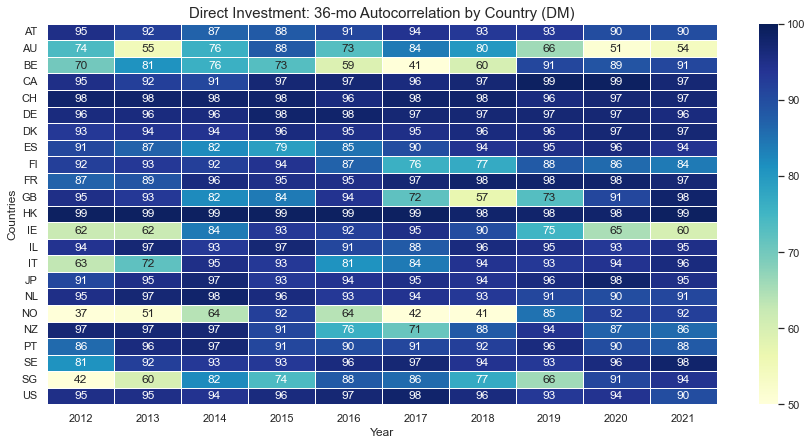

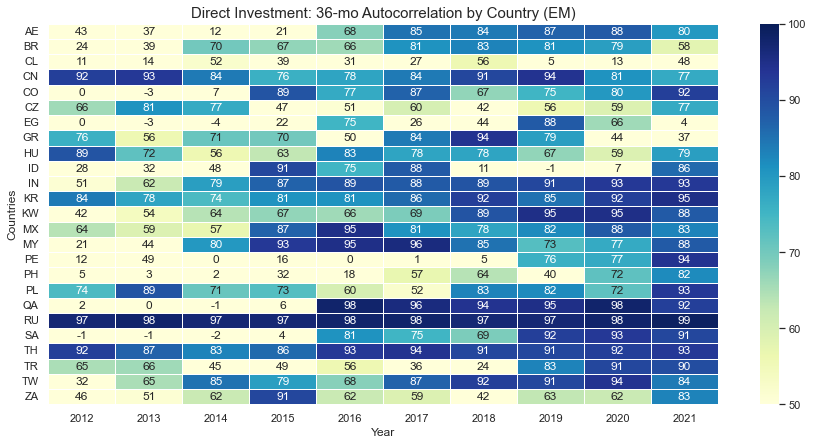

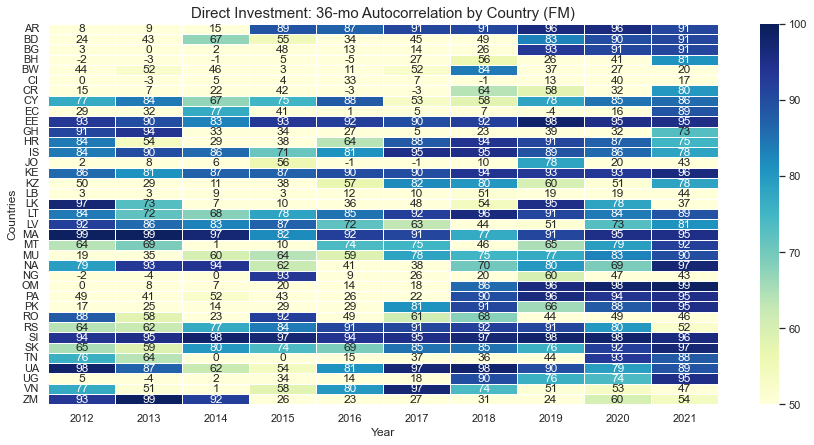

In [125]:
### IMF CDIS: AUTOCORRELATIONS

gc.collect()
### Autocorrelation performing:    
ser_current = ser_cdis_ann.fillna(0)
ser_shifted = ser_current.groupby(['Reporter', 'Partner']).shift(36).fillna(0)
df_to_auto = pd.concat([ser_current, ser_shifted], axis = 1, sort = False)
df_to_auto.columns = ['Current', 'Shifted']
df_autocorr = df_to_auto.groupby(['Date', 'Reporter']).corr()
ser_autocorr = df_autocorr['Current'][:, :, 'Shifted']
### Annual mean of autocorrelations:
ser_auto_mean = (ser_autocorr.unstack('Reporter').resample('BY').mean().stack('Reporter').sort_index() * 100).fillna(0).astype(int)
ser_auto_mean = ser_auto_mean.to_frame().join(ser_ison_status).set_index('Market', append = True).squeeze()    
### Looping over regions to illustrate:
for iter_region in list_regions:
    ### Dataset formatting:
    df_to_plot = ser_auto_mean.loc[:, :, iter_region].reset_index()
    df_to_plot['Year'] = df_to_plot['Date'].dt.year
    df_to_plot = df_to_plot.drop(['Date'], axis = 1).set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
    ### Results plotting:
    plt.figure(figsize = (15, 7))
    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True,
                             vmin = 50, vmax = 100, fmt = '.3g')
    ### Plot formatting:
    ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
    ax_heatmap.set_title('Direct Investment' + ': 36-mo Autocorrelation by Country (' + iter_region + ')', fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()   